In [136]:
import pandas as pd
import numpy as np
import io

import matplotlib.pyplot as plt

import sklearn.metrics as metrics

import pickle

from google.colab import files

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OrdinalEncoder

from sklearn import tree

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Load dataset and preprocess

In [137]:
# from google.colab import files
uploaded = files.upload()

Saving data_all_raw.csv to data_all_raw.csv


In [138]:
### Single family homes in SF Bay Area from June 2019, more details in:
### https://towardsdatascience.com/house-hunting-in-the-san-francisco-bay-area-deal-hunting-using-machine-learning-3ed6fc8e8991
data_all_raw = pd.read_csv('data_all_raw.csv')

In [139]:
# format/clean -- select columns of interest, drop rows with zeros, NaNs
data_all_temp2 = data_all_raw.dropna()
data_all_temp3 = data_all_temp2[(data_all_temp2 != 0).all(1)]

# get rid of some outliers
### Remove all houses with home size > 5000 sq ft, or lot size > 20,000 sq ft, or price > $5 million, etc.
data_all_temp4 = data_all_temp3[data_all_temp3['Home size'] < 5000]
data_all_temp5 = data_all_temp4[data_all_temp4['Lot size'] < 20000]
data_all_temp6 = data_all_temp5[data_all_temp5['Price'] < 5000000]
data_all_temp7 = data_all_temp6[data_all_temp6['Beds'] < 6]
data_all_temp8 = data_all_temp7[data_all_temp7['Baths'] < 6]

# remove spaces in column names - necessary for OLS?
data_all_temp8.columns = data_all_temp8.columns.str.replace(' ', '_')
data_all = data_all_temp8

# check for multicollinearity
correlations = data_all.corr()

# query count, mean, stdev etc. of selected data
data_all.describe()

## option to select one zipcode
#zipcode = 94401
#data_subset = data_all[data_all['Zip'] == zipcode]

,Unnamed:_0,Zip,Price,Beds,Baths,Home_size,Lot_size,Latitude,Longitude,SF_time,PA_time,School_score,Commute_time
count,5758.000000,5758.000000,5.758000e+03,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000
mean,3641.553838,94619.864536,1.194509e+06,3.426016,2.318861,1906.304967,6704.043175,37.698938,-122.115052,84.225947,84.442862,50.217367,68.383814
std,2020.278018,331.993813,7.394026e+05,0.851077,0.842316,773.425567,3411.103629,0.260709,0.231021,26.950540,33.735555,19.453980,28.831007
min,1.000000,94002.000000,1.290000e+05,1.000000,1.000000,107.000000,436.000000,37.150065,-122.687775,8.000000,5.000000,17.100000,5.000000
25%,1939.250000,94517.000000,6.790000e+05,3.000000,2.000000,1329.000000,4500.000000,37.465193,-122.274202,65.000000,60.000000,33.100000,47.000000
50%,3658.500000,94579.000000,9.959750e+05,3.000000,2.000000,1750.000000,6064.000000,37.739942,-122.102690,90.000000,85.000000,48.800000,65.000000
75%,5283.750000,94903.000000,1.469722e+06,4.000000,3.000000,2330.000000,8102.000000,37.926986,-121.943836,100.000000,115.000000,65.300000,90.000000
max,7145.000000,95391.000000,4.999888e+06,5.000000,5.500000,4955.000000,19602.000000,38.149218,-121.532356,170.000000,150.000000,89.800000,130.000000


In [140]:
# split into 80% train and 20% test

data_all, data_test = train_test_split(data_all, test_size=0.2, random_state = 42)

In [141]:
print('num rows: ', len(data_all))

num rows:  4606


In [142]:
data_all.head()

,Unnamed:_0,Address,City,State,Zip,Price,Beds,Baths,Home_size,Lot_size,Latitude,Longitude,SF_time,PA_time,School_score,Commute_time
2974,2981,618 E St,Martinez,CA,94553,495000,2,1.0,1170.0,4030.0,38.001974,-122.129694,100,130,43.3,100
2707,2714,145 Montego Dr,Hercules,CA,94547,649850,3,2.5,1802.0,5500.0,37.992717,-122.231942,95,120,44.3,95
3969,3976,109 LA Cienega Ave,Vallejo,CA,94589,350000,2,1.0,844.0,5663.0,38.127784,-122.240095,98,130,28.5,98
3641,3648,16377 Mateo St,San Leandro,CA,94578,658000,3,2.0,1507.0,5300.0,37.696221,-122.112865,85,75,28.9,75
2905,2912,2218 Hidden Lakes Ct,Martinez,CA,94553,795000,3,2.5,1901.0,6100.0,37.980937,-122.083346,100,130,43.3,100


In [143]:
# Regression metrics

# https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-scikit-learn-like-r-does
# https://machinelearningmastery.com/regression-metrics-for-machine-learning/

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
# R^2 (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a
# score of 0.0.

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
# MSE is Mean squared error regression loss.

# The MSE is calculated as the mean or average of the squared differences between predicted and expected target values in a dataset.
# The units of the MSE are squared units.
# For example, if the value represents “dollars,” then the MSE will be “squared dollars.” 
# This can be confusing for stakeholders; therefore, when reporting results, often the root mean squared error (RMSE) is used instead
def regression_results(y_true, y_pred):
    # explained_variance=metrics.explained_variance_score(y_true, y_pred)
    # mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    # median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    # r2 = metrics.r2_score(y_true, y_pred)

    # print('explained_variance: ', round(explained_variance,4))    
    # print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    # print('R_squared: ', round(r2,4))
    # print('MAE: ', round(mean_absolute_error,4))
    # print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [144]:
def display_scores (scores):
    print("Scores:", scores)
    print("\n Mean:", scores.mean())
    print("\n Standard deviation:", scores.std(),"\n")

In [145]:
# # Uncomment to check what city names are available from dataset as inputs
encoder = OrdinalEncoder()
city_cat =  data_all[["City"]]
city_cat_encoded = encoder.fit_transform(city_cat)
encoder.categories_
# print("number of cities available: ", len(encoder.categories_[0]))

[array(['Alameda', 'Alamo', 'Albany', 'Antioch', 'Atherton', 'Bay Point',
        'Belmont', 'Belvedere', 'Benicia', 'Berkeley', 'Bolinas',
        'Boulder Creek', 'Brentwood', 'Brisbane', 'Burlingame', 'Campbell',
        'Castro Valley', 'Clayton', 'Concord', 'Corte Madera', 'Crockett',
        'Cupertino', 'Daly City', 'Danville', 'Discovery Bay', 'Dublin',
        'East Palo Alto', 'El Cerrito', 'El Granada', 'El Sobrante',
        'Emeryville', 'Fairfax', 'Foster City', 'Fremont', 'Greenbrae',
        'Half Moon Bay', 'Hayward', 'Hercules', 'Hillsborough',
        'Kensington', 'Kentfield', 'La Honda', 'Lafayette', 'Larkspur',
        'Livermore', 'Los Altos', 'Los Gatos', 'Martinez', 'Menlo Park',
        'Mill Valley', 'Millbrae', 'Milpitas', 'Montara', 'Monte Sereno',
        'Moraga', 'Morgan Hill', 'Mountain House', 'Mountain View',
        'Muir Beach', 'Newark', 'Novato', 'Oakland', 'Oakley', 'Orinda',
        'Pacheco', 'Pacifica', 'Palo Alto', 'Piedmont', 'Pinole',
     

In [146]:
# Build pipeline to do any preprocessing on the raw input dataset, 
# like 1-hot encode city names
# return: Pipeline object to run fit_transform on training data, and
# transform on test data
def build_pipeline():
    # Setting remainder='passthrough' will mean that all columns not specified in 
    # the list of "transformers" will be passed through without transformation, 
    # instead of being dropped.
    cat_attribs = ["City"]
    full_pipeline = ColumnTransformer([
     ("cat", OneHotEncoder(), cat_attribs),
     ], remainder='passthrough')
    return full_pipeline

In [147]:
# check what is Spbl
# probably web scraping partially failed on a San Pablo house, got this city name instead
data_all[data_all["City"] == "Spbl"].head()

,Unnamed:_0,Address,City,State,Zip,Price,Beds,Baths,Home_size,Lot_size,Latitude,Longitude,SF_time,PA_time,School_score,Commute_time
5140,5147,1947 20th St,Spbl,CA,94806,370000,3,1.0,720.0,3049.0,37.959853,-122.349674,90,120,30.0,90
5160,5167,1947 20th St,Spbl,CA,94806,370000,3,1.0,720.0,3049.0,37.959853,-122.349674,90,120,30.0,90


## Train and Test Model

Model was split into 80% train and 20% test. The 80% train set had 10-fold cross validation applied to it. Then the error on the 20% test set was found using Root Mean Squared Error.

Best model so far: **Random forest**

Model results, rounded to 2 decimal places:

### With location - home_size, lot_size, beds, baths, latitude, longitude
**10-fold cross validated linear regression**

Eval set RMSE Mean: $436,722.87

Test set RMSE:  $448,374.74

**10-fold cross validated logistic regression**

Eval set RMSE Mean: $809,327.93

Test set RMSE:  $825,230.77

**10-fold cross validated random forest regressor**

Eval set RMSE Mean: $237,191.91

Test set RMSE:  $251,217.61

**10-fold cross validated MLP regressor (solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)**

Eval set RMSE Mean: $736,099.60

Test set RMSE:  $748,697.68

**10-fold cross validated decision tree**

Eval set RMSE Mean: $325,311.52

Test set RMSE:  $307,467.43

<!-- Best model so far: **10-fold cross validated Decision Tree** but it overfits

Model results, rounded to 2 decimal places:

### With location - home_size, lot_size, beds, baths, latitude, longitude
**10-fold cross validated linear regression**

Eval set RMSE Mean: $431,034.72

Test set RMSE:  $438,712.99

**10-fold cross validated logistic regression**

Eval set RMSE Mean: $808,039.88

Test set RMSE:  $806,180.26

**10-fold cross validated random forest regressor**

Eval set RMSE Mean: $368,075.16

Test set RMSE:  $84,256.84

**10-fold cross validated MLP regressor (solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)**

Eval set RMSE Mean: $723,943.53

Test set RMSE:  $739,338.36

**10-fold cross validated decision tree**

Eval set RMSE Mean: $487,772.16

Test set RMSE:  $5,719.33 -->

In [148]:
### sklearn ###

# set features (independent) and labels (dependent)
y = data_all['Price']

# before commute, school quality data
x2 = data_all[['Home_size', 'Lot_size', 'Beds', 'Baths', 'Latitude', 'Longitude']]
'''
x2 = data_all[['Home_size', 'Lot_size', 'Beds', 'Baths', 'Latitude', 'Longitude', 'City']]
'''

# save in order to check feature importance
orig_train = x2

'''
pipeline = build_pipeline()
print("built pipeline")
# prepared dataset
x2 = pipeline.fit_transform(x2)
'''
   
# fit data
# regressor = LinearRegression()
# regressor = DecisionTreeRegressor()
regressor = RandomForestRegressor()
# regressor = LogisticRegression()
# regressor = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
regressor.fit(x2, y)

# Train a model with 10-fold cross validation.
# Randomly splits the training set into 10 distinct subsets called folds, 
# then it trains and evaluates the Decision Tree model 10 times, 
# picking a different fold for evaluation every time and training on the 
# other 9 folds. The result is an array containing the 10 evaluation scores
# Note: sklearn cross validation expects a utility function, i.e. greater is better,
# rather than cost function like MSE where lower is better.
# That's why -scores is computed to get the RMSE.
scores = cross_val_score(regressor, x2, y, scoring="neg_mean_squared_error", cv = 10)
tree_rmse_scores  = np.sqrt(-scores)
display_scores(tree_rmse_scores)

test_y = data_test['Price']
test_x2 = data_test[['Home_size', 'Lot_size', 'Beds', 'Baths', 'Latitude', 'Longitude']]

# predict values based on model
# y_pred2 = regressor.predict(x2) # listing data only
y_pred2 = regressor.predict(test_x2) # listing data only

# calculate difference between predicted and actual prices
# diff = round((y - y_pred2), 6)
diff = round((test_y - y_pred2), 6)

# add difference to full data set
# data_all['Price_difference'] = diff

Scores: [250836.69150443 221711.95629422 237074.50043734 231190.86085194
 227363.13196297 268739.4528677  242810.37885939 247577.02760642
 212494.60793909 234964.30148649]

 Mean: 237476.29098100163

 Standard deviation: 15189.522201132897 



In [149]:
# Root Mean Squared Error as the evaluation metric
# regression_results(y, y_pred2)
regression_results(test_y, y_pred2)

RMSE:  250103.2123


### Save trained model and pipeline

In [150]:
# save the model
file = open("house_price_model.pkl", 'wb')
pickle.dump(regressor, file)
file.close()

In [151]:
'''
# save the pipeline fitted on training dataset
file = open("house_price_pipeline.pkl", 'wb')
pickle.dump(pipeline, file)
file.close()
'''

'\n# save the pipeline fitted on training dataset\nfile = open("house_price_pipeline.pkl", \'wb\')\npickle.dump(pipeline, file)\nfile.close()\n'

### Interpret Decision Tree Results

In [152]:
columns = orig_train.columns
print('num original train features:', len(columns))
# print(x2)
importance = regressor.feature_importances_
print('num feature importances:', len(importance))

num original train features: 6
num feature importances: 6


Try to estimate feature importances of original feature as sum of feature importances of corresponding features after OHE

In [153]:
estimated_importance = importance

'''
# There were 7 original input columns: 'Home_size', 'Lot_size', 'Beds', 'Baths', 'Latitude', 'Longitude', 'City'
# There are 103 cities available. After 1-hot encoding, the City column becomes 103 separate columns. 
# 6 original + 103 1-hot = 109 columns = 109 elements in feature importance array
# print(columns)
importance_without_city = importance[:6] 
# print(len(importance_without_city))
# print(importance_without_city)
# Dividing by 103 only to make visualization of other features easier to see
sum_city_importance = sum(importance[6:]) / 103
print('estimated cities importance:', sum_city_importance)
# print(type(sum_city_importance))
estimated_importance = np.append(importance_without_city, sum_city_importance)
print('total num feature importances:', len(estimated_importance))
print(estimated_importance)
'''

"\n# There were 7 original input columns: 'Home_size', 'Lot_size', 'Beds', 'Baths', 'Latitude', 'Longitude', 'City'\n# There are 103 cities available. After 1-hot encoding, the City column becomes 103 separate columns. \n# 6 original + 103 1-hot = 109 columns = 109 elements in feature importance array\n# print(columns)\nimportance_without_city = importance[:6] \n# print(len(importance_without_city))\n# print(importance_without_city)\n# Dividing by 103 only to make visualization of other features easier to see\nsum_city_importance = sum(importance[6:]) / 103\nprint('estimated cities importance:', sum_city_importance)\n# print(type(sum_city_importance))\nestimated_importance = np.append(importance_without_city, sum_city_importance)\nprint('total num feature importances:', len(estimated_importance))\nprint(estimated_importance)\n"

In [154]:
combo = pd.Series(estimated_importance, columns)
combo

Home_size    0.322919
Lot_size     0.036569
Beds         0.005038
Baths        0.015233
Latitude     0.347366
Longitude    0.272875
dtype: float64

Text(0.5, 1.0, 'Random Forest Feature Importances')

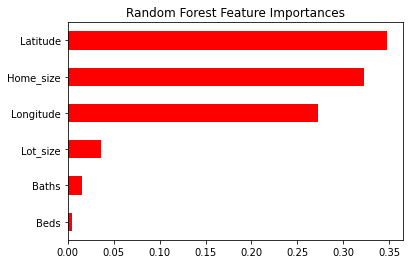

In [158]:
plt.figure(figsize=(6,4))
combo.sort_values().plot.barh(color='red')
# plt.title('Decision Tree Feature Importances')

plt.title('Random Forest Feature Importances')

### View Decision Tree

In [156]:
# col_list = list(columns)
# encoded_cities_list = list(encoder.categories_[0])
# print(col_list)
# print(encoded_cities_list)
# feature_names = col_list + encoded_cities_list
# print(len(feature_names))
# print(feature_names)

feature_names = list(columns)

[Text(0.5, 0.9, 'Home_size <= 2487.5\nsquared_error = 565903991334.842\nsamples = 2877\nvalue = 1201285.344'),
 Text(0.25, 0.7, 'Latitude <= 37.589\nsquared_error = 272253111819.553\nsamples = 2298\nvalue = 1020037.575'),
 Text(0.125, 0.5, 'Longitude <= -121.998\nsquared_error = 267799509134.259\nsamples = 762\nvalue = 1389858.374'),
 Text(0.0625, 0.3, 'Latitude <= 37.455\nsquared_error = 367220311555.745\nsamples = 295\nvalue = 1687999.981'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'Home_size <= 1461.0\nsquared_error = 101901082127.728\nsamples = 467\nvalue = 1190269.132'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'Longitude <= -122.4\nsquared_error = 174578223477.423\nsamples = 1536\nvalue = 838820.86'),
 Text(0.3125, 0.3, 'Longitude <= -122.63\nsquared_error = 305493324919.111\nsamples = 317\nvalue = 1267735.84'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  

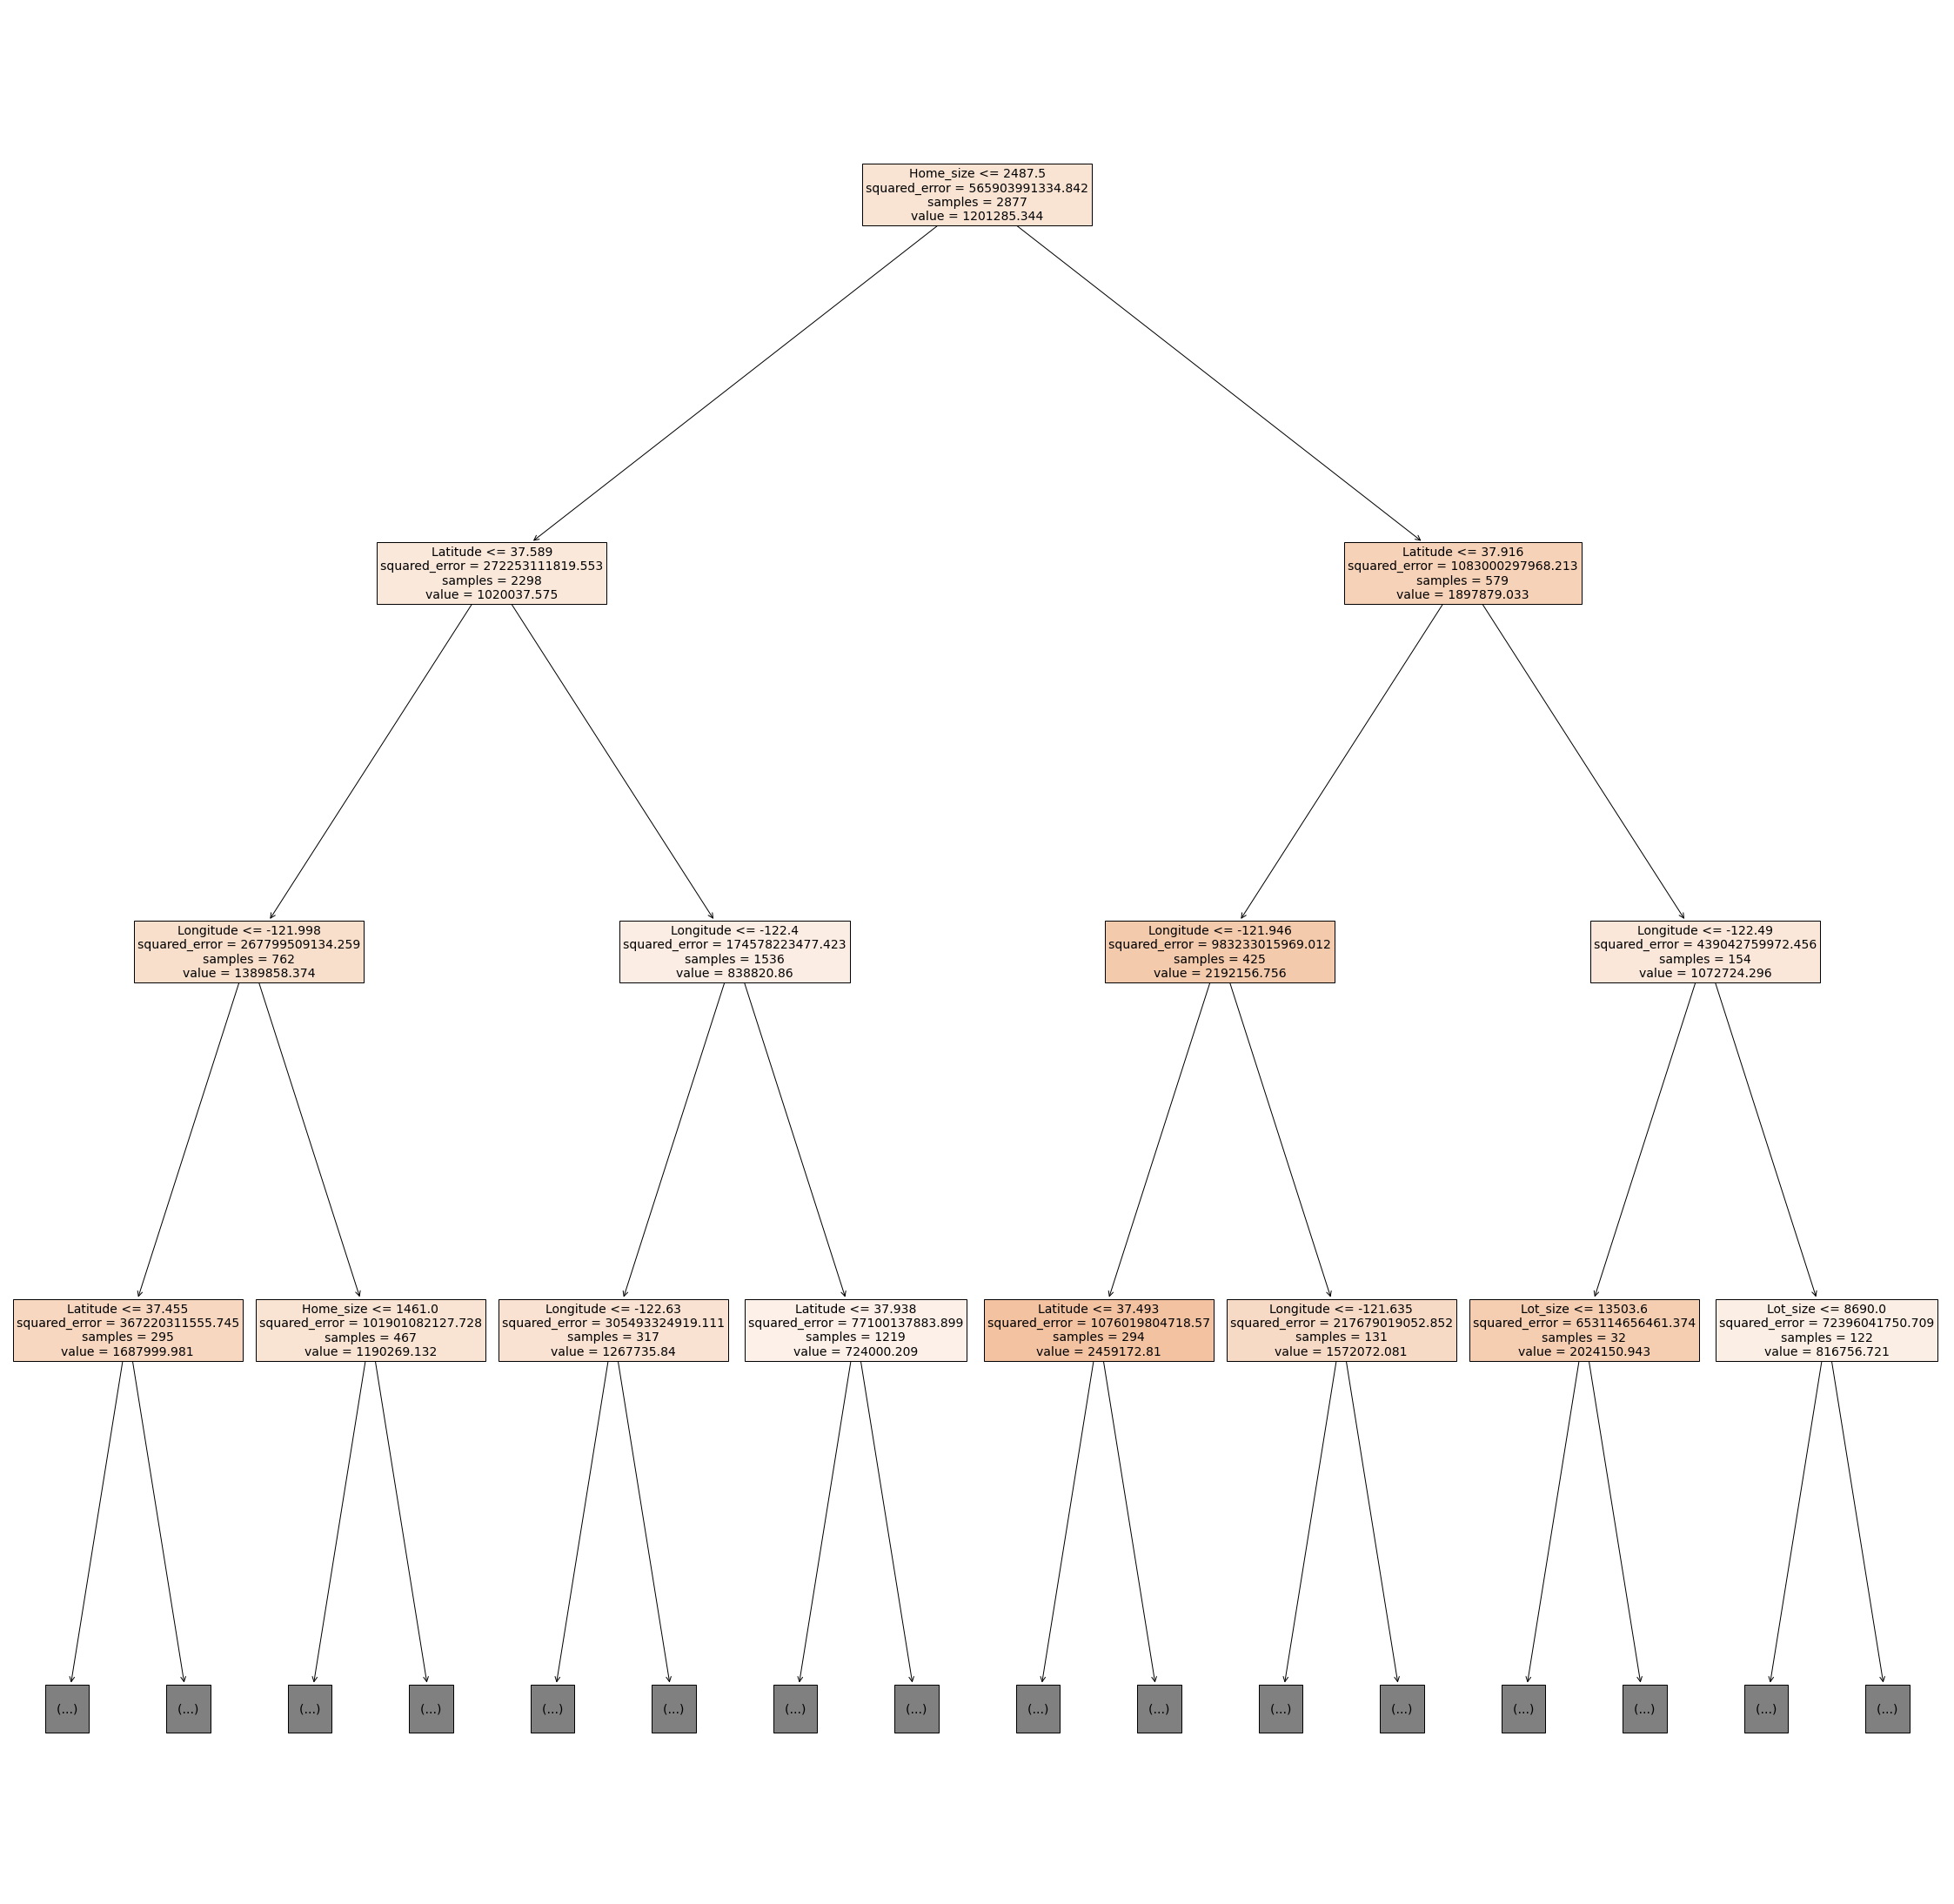

In [159]:
_, ax = plt.subplots(figsize=(40,40)) # Resize figure
# tree.plot_tree(regressor, fontsize=14, max_depth=3, filled=True, ax=ax, feature_names=feature_names)

tree.plot_tree(regressor.estimators_[0], fontsize=14, max_depth=3, filled=True, ax=ax, feature_names=feature_names)

### Check model can run prediction given inputs 
### With arbitrary first row of training values, expect prediction = $1,595,000


City names (Spbl is San Pablo):

'Alameda', 'Alamo', 'Albany', 'Antioch', 'Atherton', 'Bay Point',
        'Belmont', 'Belvedere', 'Benicia', 'Berkeley', 'Bolinas',
        'Boulder Creek', 'Brentwood', 'Brisbane', 'Burlingame', 'Campbell',
        'Castro Valley', 'Clayton', 'Concord', 'Corte Madera', 'Crockett',
        'Cupertino', 'Daly City', 'Danville', 'Discovery Bay', 'Dublin',
        'East Palo Alto', 'El Cerrito', 'El Granada', 'El Sobrante',
        'Emeryville', 'Fairfax', 'Foster City', 'Fremont', 'Greenbrae',
        'Half Moon Bay', 'Hayward', 'Hercules', 'Hillsborough',
        'Kensington', 'Kentfield', 'La Honda', 'Lafayette', 'Larkspur',
        'Livermore', 'Los Altos', 'Los Gatos', 'Martinez', 'Menlo Park',
        'Mill Valley', 'Millbrae', 'Milpitas', 'Montara', 'Monte Sereno',
        'Moraga', 'Morgan Hill', 'Mountain House', 'Mountain View',
        'Muir Beach', 'Newark', 'Novato', 'Oakland', 'Oakley', 'Orinda',
        'Pacheco', 'Pacifica', 'Palo Alto', 'Piedmont', 'Pinole',
        'Pittsburg', 'Pleasant Hill', 'Pleasanton', 'Point Richmond',
        'Portola Valley', 'Redwood City', 'Richmond', 'Rodeo',
        'San Anselmo', 'San Bruno', 'San Carlos', 'San Francisco',
        'San Jose', 'San Leandro', 'San Lorenzo', 'San Mateo', 'San Pablo',
        'San Rafael', 'San Ramon', 'Santa Clara', 'Saratoga', 'Sausalito',
        'South San Francisco', 'Spbl', 'Stanford', 'Stinson Beach',
        'Sunnyvale', 'Sunol', 'Tiburon', 'Tracy', 'Union City', 'Vallejo',
        'Walnut Creek', 'Woodside'

In [160]:
with open('house_price_model.pkl', 'rb') as pickle_in:
  model = pickle.load(pickle_in) 
  home_size = 2220.0 
  lot_size = 3999.0
  beds = 4
  baths = 2.0 
  latitude = 37.521972
  longitude = -122.294079 	
  # city = 'Belmont'
  # get prediction
  # input_cols = [[home_size, lot_size, beds, baths, latitude, longitude, city]]
  input_cols = [[home_size, lot_size, beds, baths, latitude, longitude]]
  input_df = pd.DataFrame(
            data=input_cols, 
            index=np.arange(len(input_cols)), 
            # columns=['Home_size', 'Lot_size', 'Beds', 'Baths', 'Latitude', 'Longitude', 'City']
            columns=['Home_size', 'Lot_size', 'Beds', 'Baths', 'Latitude', 'Longitude']
        )
  # prepared_data = pipeline.transform(input_df)
  # prediction = model.predict(prepared_data)
  prediction = model.predict(input_df)
  output = round(prediction[0], 2)
  print('Your predicted house price: $' + str(output))

Your predicted house price: $1736228.87
